In [1]:
import psycopg2
import pandas as pd

#Connect to database
conn = psycopg2.connect(database="RecallsReviews", user="unsafefoods", password="Password1", host="unsafefoods.csya4zsfb6y4.us-east-1.rds.amazonaws.com", port="5432")

print("Opened database successfully")


Opened database successfully


In [2]:
#create a cursor to execute SQL
cur = conn.cursor()


In [3]:
cur.execute('SELECT review_text from review where product_id in (SELECT product_id from recalledproduct);')

In [4]:
review_text = cur.fetchall()

In [5]:
for text in review_text:
    print(text)

('Love these! Taste is perfect  not too sweet  lots of whole nuts and fruit. I plan on trying other flavors.',)
('Great snack bars. Kashi never seems to disappoint. The ingredients are natural  no corn syrup or artificial anything  high in fiber and low in fat.  The almonds are big and the fruit is moist.  They are chewie but not sticky.  These are my favorite Kashi bars.',)
('Im unimpressed with these.  They are incredibly dense  so if you want to lose weight  avoid these.  They do taste OK  but not great.  Ive had better tasting granola bars.',)
('Now  this is trail mix I`m  talking about. not rhe peanut butter or the flaxceed bars.This one is outstanding in flavor and in texture (though a little lumpy to chew and maybe a litttle dry)and quality ingredients.A great granola bar.(as a tip put a thin coating of splenda or stevia across the top to give it a little more sweetness)When amazon ran out a few weeks ago  i ordered a case from another vendor at a slightly higher price That is s

In [6]:
cur.execute('SELECT review_text from review where product_id not in (select product_id from recalledproduct);')

In [7]:
not_recalled_review_text = cur.fetchall()

In [8]:
#subset just for testing
not_recalled_review_text = not_recalled_review_text[:500]

In [9]:
conn.close()

In [10]:
##Tokenize review text for each review
import numpy as np
import re
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.lancaster import LancasterStemmer
st = LancasterStemmer()

In [11]:
recalled_reviews = []
for review in review_text:
    recalled_reviews.append(review[0])

for row in range(len(recalled_reviews)):
    recalled_reviews[row] = recalled_reviews[row].replace("'", "")
    recalled_reviews[row] = re.sub('[^a-zA-Z\s]',' ', recalled_reviews[row])

In [12]:
reviews_not_recalled = []
for review in not_recalled_review_text[:500]:
    reviews_not_recalled.append(review[0])

for row in range(len(reviews_not_recalled)):
    reviews_not_recalled[row] = reviews_not_recalled[row].replace("'", "")
    reviews_not_recalled[row] = re.sub('[^a-zA-Z\s]',' ', reviews_not_recalled[row])

In [13]:
recalled_reviews

['Love these  Taste is perfect  not too sweet  lots of whole nuts and fruit  I plan on trying other flavors ',
 'Great snack bars  Kashi never seems to disappoint  The ingredients are natural  no corn syrup or artificial anything  high in fiber and low in fat   The almonds are big and the fruit is moist   They are chewie but not sticky   These are my favorite Kashi bars ',
 'Im unimpressed with these   They are incredibly dense  so if you want to lose weight  avoid these   They do taste OK  but not great   Ive had better tasting granola bars ',
 'Now  this is trail mix I m  talking about  not rhe peanut butter or the flaxceed bars This one is outstanding in flavor and in texture  though a little lumpy to chew and maybe a litttle dry and quality ingredients A great granola bar  as a tip put a thin coating of splenda or stevia across the top to give it a little more sweetness When amazon ran out a few weeks ago  i ordered a case from another vendor at a slightly higher price That is some

In [14]:
reviews_not_recalled

['Just another flavor of Kit Kat but the taste is unique and a bit different   The only thing that is bothersome is the price   I thought it was a bit expensive    ',
 'I bought this on impulse and it comes from Japan   which amused my family   all those weird stamps and markings on the package  So that was fun   It said it would take about a month to arrive and it did take that long   I was hoping for a more interesting taste but to our family   it just tasted a bit less flavorful or weaker than the standard milk chocolate kit kat   The green tea flavor was too subtle for the sugar and it just tasted sweet  The wafers were very crispy  and that was good   but it tasted a bit anemic to us Im happy I bought it  but dont need to buy it again ',
 'Really good  Great gift for any fan of green tea  Just so expensive to purchase candy from across the sea ',
 'I had never had it before  was curious to see what it was like  Smooth  great subtle good flavor  I am ordering more and plan to make 

In [15]:
recall_tokens = [word_tokenize(review) for review in recalled_reviews]

In [16]:
no_recall_tokens = [word_tokenize(review) for review in reviews_not_recalled]

In [17]:
##Separate strings with multiple uppercase characters (e.g., gCholesterol, VeronaStarbucks). This should (hopefully)
## take care of situations where the reviews included returns that were not treated as spaces in the raw text file
def split_uppercase(tokens):
    tokens_II = np.empty((len(tokens),0)).tolist()
    for review in tokens:
        n = tokens.index(review)
        for word in review:
            split = re.sub(r'([A-Z][a-z])', r' \1', word)
            tokens_II[n].append(split)
    return tokens_II

recall_tokens = split_uppercase(recall_tokens)
no_recall_tokens = split_uppercase(no_recall_tokens)

In [18]:
##Make all text lower case
def make_lowercase(tokens):
    tokens_final = np.empty((len(tokens),0)).tolist()
    for review in tokens:
        n = tokens.index(review)
        for word in review:
            lowercase_word = word.lower()
            tokens_final[n].append(lowercase_word)
    return tokens_final

recall_tokens = make_lowercase(recall_tokens)
no_recall_tokens = make_lowercase(no_recall_tokens)

In [19]:
##Remove stopwords and stem
stopwords = stopwords.words('english')

def stem_tokens(tokens):
    stemmed_token = np.empty((len(tokens),0)).tolist()
    for review in tokens:
        n = tokens.index(review)
        for word in review:
            if word not in stopwords:
                stem = st.stem(word)
                stemmed_token[n].append(stem)
    return stemmed_token
        
recall_stemmed = stem_tokens(recall_tokens)
no_recall_stemmed = stem_tokens(no_recall_tokens)

In [20]:
##Manipulate stemmed text to be string instead of list (needed for count vectorizer)
def make_string(text):
    final_review_text = []
    for review in text:
        for word in review:
            n = review.index(word)
            if n == 0:
                string = review[n]
            else:
                string = string + " " + review[n]
        final_review_text.append(string)
    return final_review_text

final_text_recall = make_string(recall_stemmed)
final_text_no_recall = make_string(no_recall_stemmed)
#print(final_text_recall)
#print(final_text_no_recall)

In [21]:
##Count Vectorizer Matrix
import numpy as np
import scipy
from scipy.sparse import csr_matrix, vstack, hstack
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(binary=False, ngram_range=(1, 1)) ##Removed stopwords before stemming so don't apply here

In [22]:
#combine recalled and not recalled
all_reviews = final_text_no_recall + final_text_recall
len(all_reviews)

1154

In [23]:
food_review_text = vectorizer.fit_transform(all_reviews)

##Remove if word is in less than 5 reviews - Uncomment if want to do this 

#counts = scipy.sparse.csr_matrix.sum(food_review_text, axis=0)
#food_review_text = np.transpose(vstack([food_review_text,counts]))
#food_review_text = pd.DataFrame(food_review_text.todense(), index = vectorizer.get_feature_names())

#last_col = food_review_text.shape[1] - 1
#food_review_text = food_review_text[food_review_text[last_col] > 4]
#del food_review_text[last_col]

In [24]:
##TFIDF Weighting
from sklearn.feature_extraction.text import TfidfTransformer
#food_review_text = food_review_text.transpose()

transformer = TfidfTransformer()
tfidf_matrix = transformer.fit_transform(food_review_text)

# Part 1

# Linear SVM Analysis

In [25]:
##Generic SVM analysis
from sklearn.svm import LinearSVC

In [26]:
model = LinearSVC(C=1)

In [27]:
#get tags
not_recalled = [0] * 500
recalled = [1] * len(final_text_recall)
recall_tags = not_recalled + recalled

In [28]:
results = model.fit(tfidf_matrix, np.asarray(recall_tags))

In [29]:
term_names = vectorizer.get_feature_names()
term_names = pd.DataFrame(term_names)
#term_names = pd.DataFrame(food_review_text.columns.values)
#cat_names = pd.DataFrame(category_df.columns.values)
#X_col_names = pd.concat([term_names,cat_names], axis=0)
#X_col_names = X_col_names.reset_index(drop=True)

results_coef = results.coef_
results_coef_array = np.transpose(np.asarray(results_coef, dtype=np.float32))
results_df_coef = pd.DataFrame(results_coef_array, columns=['Coef'], dtype=float)
results_dataframe = pd.concat([term_names, results_df_coef], axis=1)

In [30]:
results_dataframe = results_dataframe.sort_values(by='Coef', ascending=False)

In [31]:
results_dataframe

,0,Coef
730,coconut,2.762100
3636,soy,1.716270
2809,paprik,1.567561
2849,peanut,1.470898
1564,garl,1.439277
597,cer,1.426565
3579,snack,1.372131
2642,nut,1.321411
249,baby,1.313158
1788,healthy,1.303789


In [32]:
results_dataframe[(results_dataframe[0] == 'sick') == True]

,0,Coef
3504,sick,0.419183


# Part 2

# Lasso Analysis

In [33]:
from sklearn.linear_model import lasso_path
alphas, coef_path, _ = lasso_path(tfidf_matrix, recall_tags, alphas=[1e-03,1e-04,4e-05])

In [34]:
term_names = vectorizer.get_feature_names()
term_names = pd.DataFrame(term_names)

In [35]:
results2_coef_array = (np.asarray(coef_path, dtype=np.float32))
results2_coef_df = pd.DataFrame(results2_coef_array, columns=['a = 1e-03','a = 1e-04', 'a = 4e-05'], dtype=float)
results2_dataframe = pd.concat([term_names, results2_coef_df], axis=1)

In [36]:
results2_dataframe_keep = results2_dataframe[(results2_dataframe['a = 1e-03'] > 0) | (results2_dataframe['a = 1e-04'] > 0) \
                                             |(results2_dataframe['a = 4e-05'] > 0)]
results2_dataframe_keep

,0,a = 1e-03,a = 1e-04,a = 4e-05
19,accord,0.000000,0.300560,0.585542
21,account,0.000000,0.354230,0.848112
31,acquir,0.000000,0.049554,0.000000
34,act,0.000000,0.190105,0.443747
38,ad,0.479406,0.352180,0.377630
42,addict,0.000000,0.359234,0.798734
44,addit,0.000000,0.299100,0.321595
52,adult,0.000000,0.729498,0.770653
53,adv,0.000000,0.038428,0.554147
54,advert,0.000000,0.404493,0.871586


# Part 4

## Unsupervised NMF first, Supervised learning second

In [38]:
## Non-negative matrix factorization
#must install nimfa before use

import nimfa

tfidf_matrix_nmf = np.transpose(tfidf_matrix)
nmf = nimfa.Nmf(tfidf_matrix_nmf, rank=30, seed='random_c', update="divergence", objective="div")
fit = nmf()

C:\Users\cvint\Anaconda3\lib\site-packages\matplotlib\pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


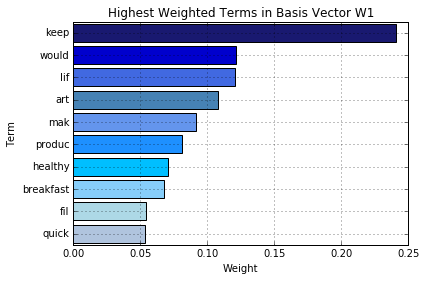

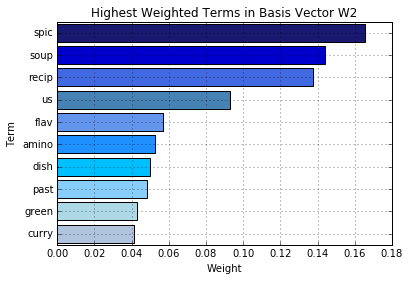

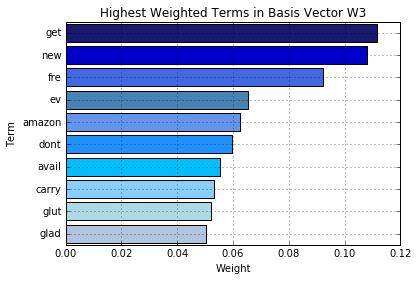

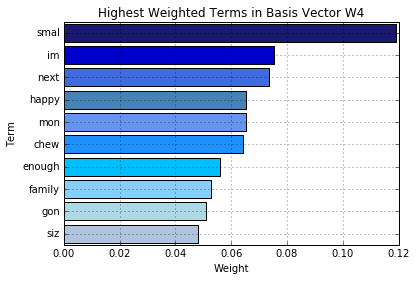

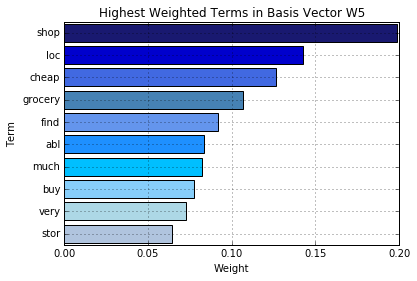

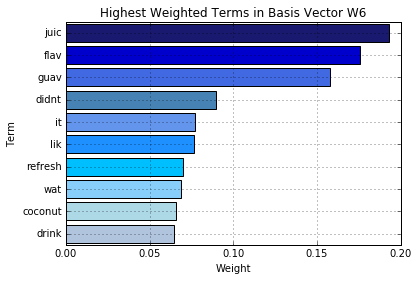

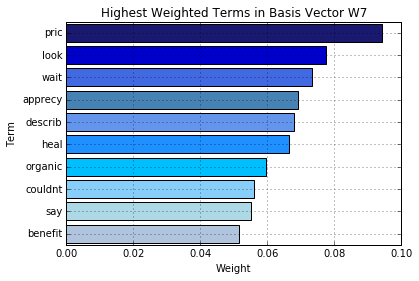

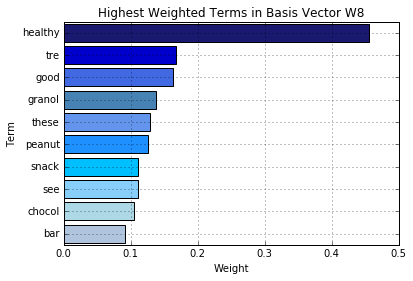

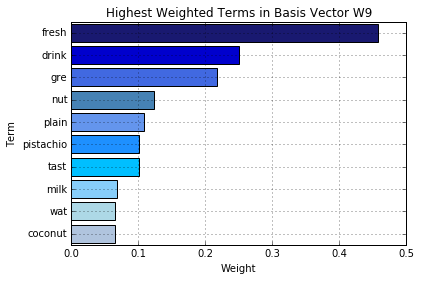

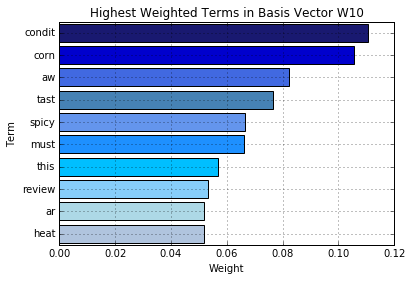

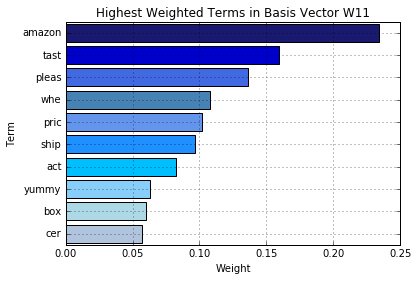

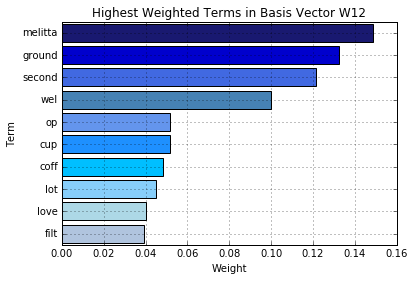

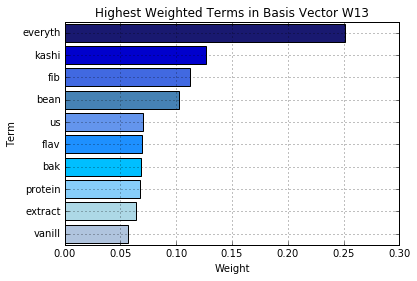

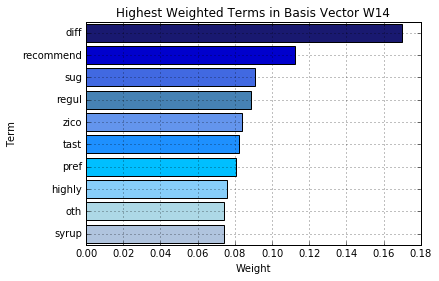

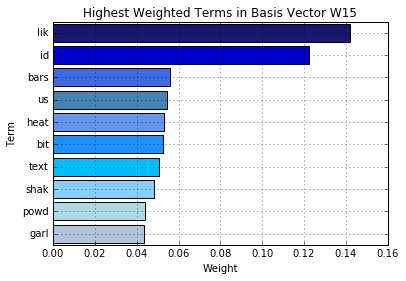

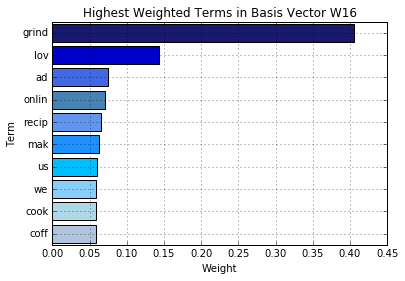

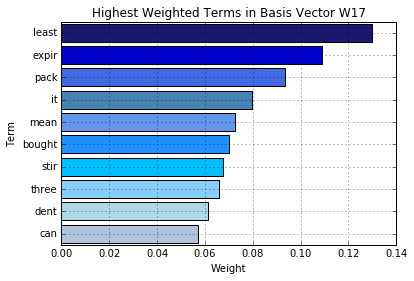

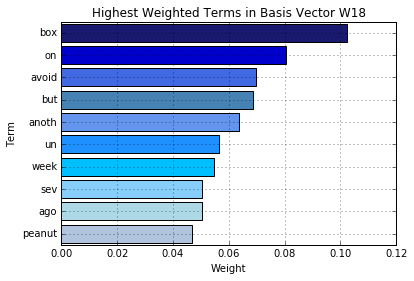

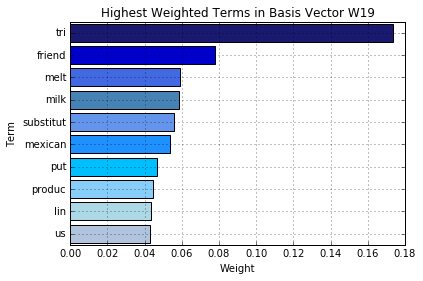

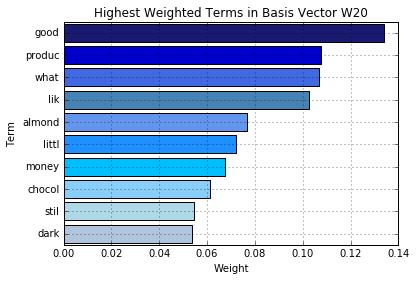

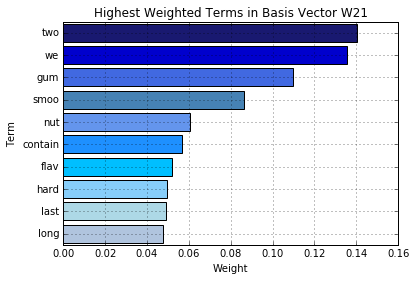

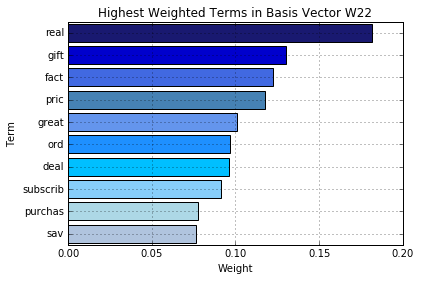

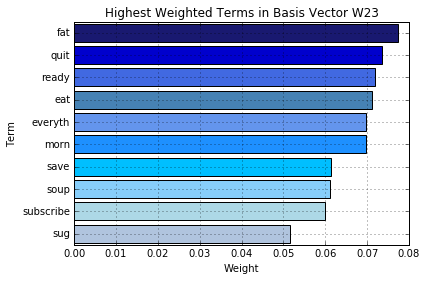

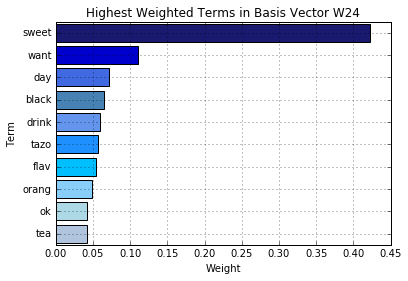

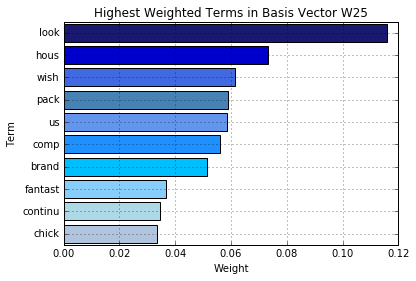

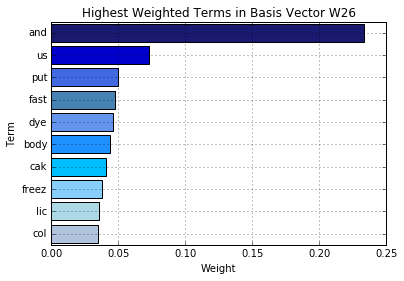

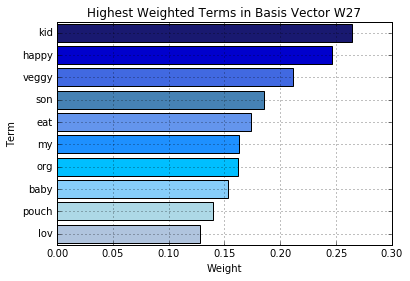

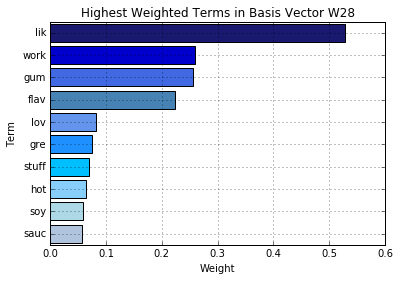

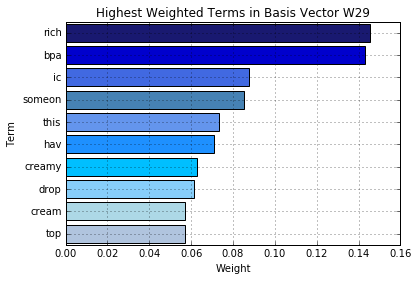

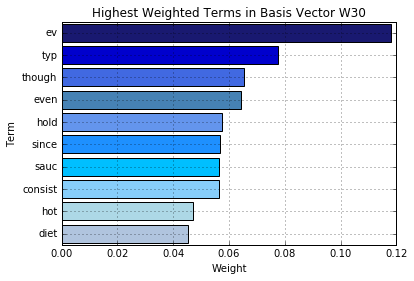

In [39]:
##Check out 
feature_names = vectorizer.get_feature_names()
import matplotlib.pylab as plb
%matplotlib inline

def plot(W,termlist):
    for c in range(W.shape[1]):
        top10 = np.argsort(np.asarray(W[:,c].todense()).flatten())[-10:]
        val = W[top10, c].todense()
        plb.figure(c + 1)
        plb.barh(np.arange(10) + .5, val, color=['LightSteelBlue', 'LightBlue', 'LightSkyBlue', 'DeepSkyBlue', 'DodgerBlue', 
                                                 'CornflowerBlue','SteelBlue','RoyalBlue','MediumBlue', 'MidnightBlue'], align='center')
        plb.yticks(np.arange(10) + .5, [feature_names[i] for i in top10][::-1])
        plb.xlabel("Weight")
        plb.ylabel("Term")
        plb.title("Highest Weighted Terms in Basis Vector W%d" % (c + 1))
        plb.grid(True)
    
plot(fit.basis(), feature_names)

In [41]:
##Generic SVM analysis using lower dimensions from topic modeling
from sklearn.svm import LinearSVC

H = np.transpose(fit.coef())

model = LinearSVC(C=1)
results = model.fit(H, recall_tags)

In [43]:
results_coef_array = np.transpose(np.asarray(results.coef_, dtype=np.float32))
results_df_coef = pd.DataFrame(results_coef_array, columns=['Coef'], dtype=float)
results_df_coef = results_df_coef.sort_values(by='Coef', ascending=False)
results_df_coef

,Coef
26,3.146194
5,1.563843
7,1.272808
8,0.953704
10,0.342715
16,0.316888
22,0.307553
21,0.184381
13,0.045325
14,-0.005340


In [45]:
##Lasso
from sklearn.linear_model import lasso_path
alphas, coef_path, _ = lasso_path(H, recall_tags, alphas=[1e-03,1e-04,4e-05])


results3_coef_array = (np.asarray(coef_path, dtype=np.float32))
results3_coef_df = pd.DataFrame(results3_coef_array, columns=['a = 1e-03','a = 1e-04', 'a = 4e-05'], dtype=float)

results3_coef_df

,a = 1e-03,a = 1e-04,a = 4e-05
0,0.460071,0.495174,0.497473
1,0.201173,0.230699,0.232691
2,0.222572,0.252648,0.254672
3,0.209799,0.242742,0.244950
4,0.574135,0.611954,0.614492
5,1.044004,1.059254,1.060261
6,0.141844,0.180839,0.183407
7,1.421175,1.443933,1.445397
8,1.233057,1.265951,1.268078
9,0.203206,0.236107,0.238286
